## Health Insurance Cross Sell Prediction

Create a model to help predict health insurance owners who might also be interested in vehicle insurance


Building a model to predict if a customer would be interested in also purchasing vehicle insurance would help the marketing department with its efforts to target marketing to those most likely to purchase.


## Data Description


| Variable | Definition |
| --- | ---|
| id | Unique ID for the customer |
| --- | --- |
| Gender | Gender of the customer |
| --- | --- |
| Age | Age of the customer |
| --- | --- |
| Driving_License | 0 : Customer does not have DL, 
| --- | 1 : Customer already has DL |
| --- | --- |
| Region_Code | Unique code for the region of the customer |
| --- | --- |
| Previously_Insured | 1 : Customer already has Vehicle Insurance, 
| --- | 0 : Customer doesn't have Vehicle Insurance |
| --- | --- |
| Vehicle_Age | Age of the Vehicle |
| --- | --- |
| Vehicle_Damage | 1 : Customer had vehicle damage in the past. 
| --- | 0 : Customer didn't have vehicle damage in the past. |
| --- | --- |
| Annual_Premium | The insurance premium for the year. |
| --- | --- |
| PolicySalesChannel | Anonymized Code for the channel of outreaching to the customer ie. 
| --- | Different Agents, Over Mail, Over Phone, In Person, etc. |
| --- | --- |
| Vintage | Number of days, customer has been associated with the company |
| --- | --- |
| Response | 1 : Customer is interested, 
| --- | 0 : Customer is not interested |



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import display

## Data Loading

In [2]:
url = ('https://raw.githubusercontent.com/DonAvery/health-insurance-cross-sell-prediction/main/data/train.csv')

df = pd.read_csv(url)

In [3]:
df.shape

(381109, 12)

## EDA

In [4]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
df.columns = df.columns.str.lower()

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower()

We have to remove the > and < signs for XGBoost training later. We will replace '<' with 'l' and '>' with 'g'.

In [6]:
df['vehicle_age'] = df['vehicle_age'].str.replace('<', 'l')
df['vehicle_age'] = df['vehicle_age'].str.replace('>', 'g')

In [7]:
df.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,male,44,1,28.0,0,g 2 years,yes,40454.0,26.0,217,1
1,2,male,76,1,3.0,0,1-2 year,no,33536.0,26.0,183,0
2,3,male,47,1,28.0,0,g 2 years,yes,38294.0,26.0,27,1
3,4,male,21,1,11.0,1,l 1 year,no,28619.0,152.0,203,0
4,5,female,29,1,41.0,1,l 1 year,no,27496.0,152.0,39,0


In [8]:
df.head().T

,0,1,2,3,4
id,1,2,3,4,5
gender,male,male,male,male,female
age,44,76,47,21,29
driving_license,1,1,1,1,1
region_code,28.0,3.0,28.0,11.0,41.0
previously_insured,0,0,0,1,1
vehicle_age,g 2 years,1-2 year,g 2 years,l 1 year,l 1 year
vehicle_damage,yes,no,yes,no,no
annual_premium,40454.0,33536.0,38294.0,28619.0,27496.0
policy_sales_channel,26.0,26.0,26.0,152.0,152.0


In [9]:
df.shape

(381109, 12)

In [10]:
df.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [11]:
numerical = (df.dtypes[df.dtypes != 'object'].index)

In [12]:
df.response

0         1
1         0
2         1
3         0
4         0
         ..
381104    0
381105    0
381106    0
381107    0
381108    0
Name: response, Length: 381109, dtype: int64

In [13]:
df.response.count()

381109

In [14]:
df.response.sum()

46710

In [15]:
df.response.sum()/df.response.count()

0.12256336113815208

In [16]:
df.isnull().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


In [18]:
binaries = ['gender', 'driving_license', 'previously_insured', 'vehicle_damage', 'response']

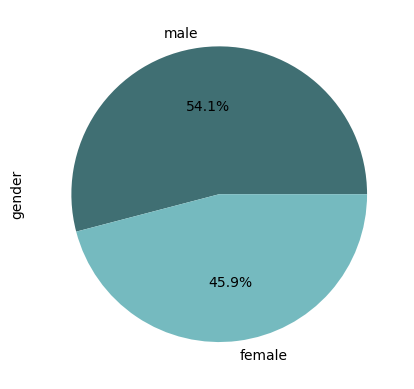

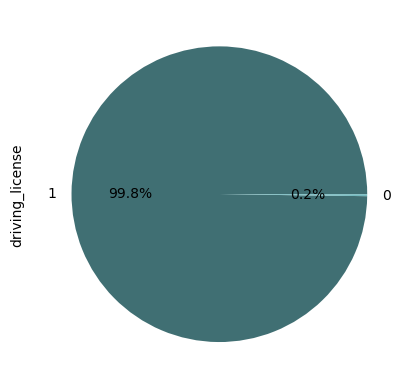

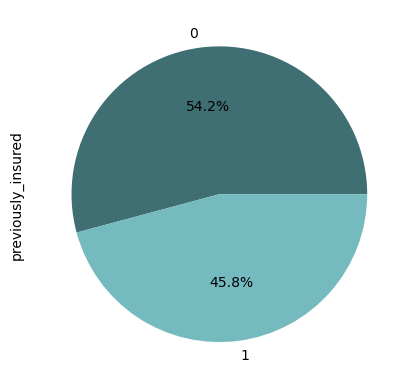

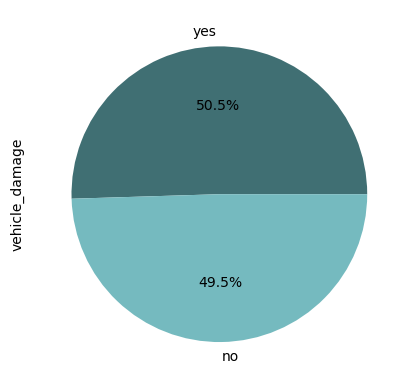

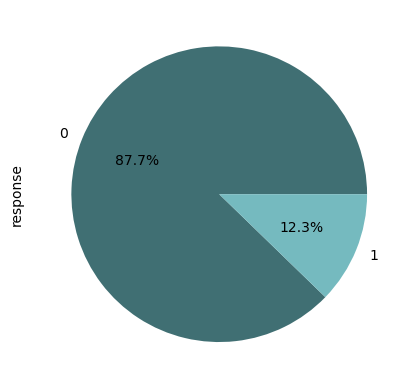

In [19]:
colors = ['#406F73', '#75BABF']

for b in binaries:
    df[b].value_counts().plot(kind = 'pie', autopct='%.1f%%', colors=colors)
    plt.show()

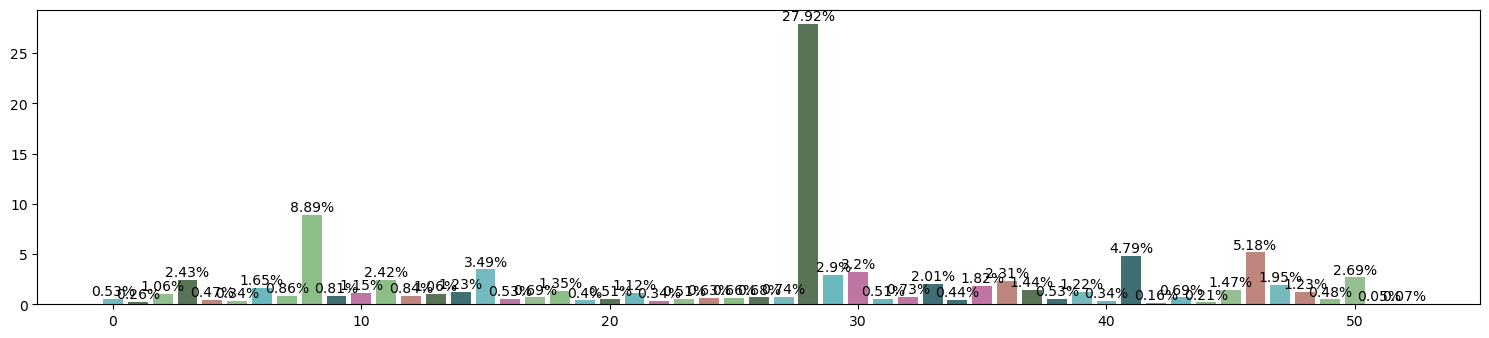

In [20]:
colors = ['#597357', '#8CBF88', '#BF867E', '#406F73', '#75BABF', '#BF75A1', '#6BB9BF', '#95BF91']

percentages = round(((df['region_code'].value_counts() / df['region_code'].shape[0]) * 100), 2)

plt.rcParams["figure.figsize"] = [15.00, 3.50]
plt.rcParams["figure.autolayout"] = True
labels = df['region_code'].unique()

plt.figure()

p1 = plt.bar(percentages.index, percentages, color=colors)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=10)

plt.show()

In [21]:
pd.value_counts(df['region_code'])

28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: region_code, dtype: int64

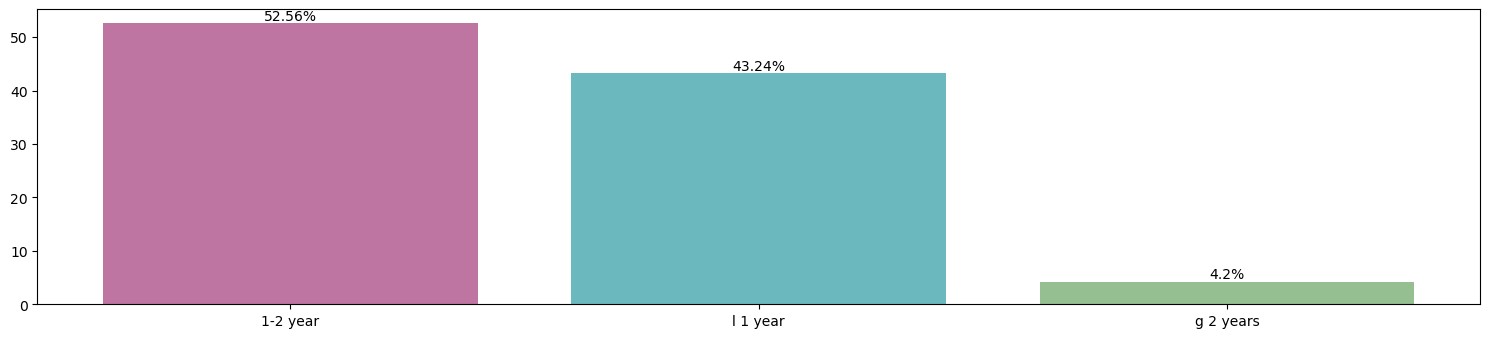

In [22]:
colors = ['#BF75A1', '#6BB9BF', '#95BF91']

percentages = round(((df['vehicle_age'].value_counts() / df['vehicle_age'].shape[0]) * 100), 2)

plt.rcParams["figure.figsize"] = [15.00, 3.50]
plt.rcParams["figure.autolayout"] = True
labels = df['vehicle_age'].unique()

plt.figure()

p1 = plt.bar(percentages.index, percentages, color=colors)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=10)

plt.show()

array([[<AxesSubplot: title={'center': 'age'}>]], dtype=object)

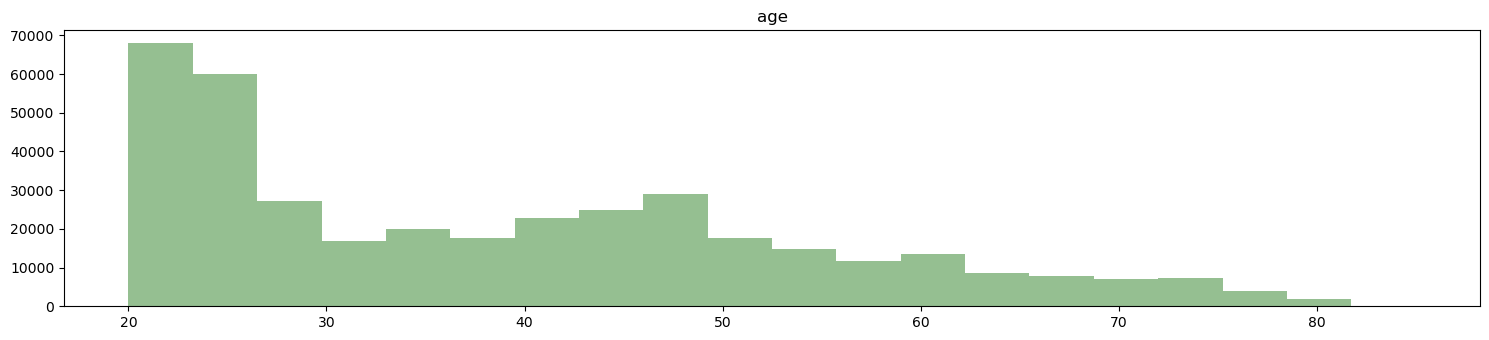

In [23]:
df.hist(column='age', bins=20, color = '#95BF91', grid=False)

array([[<AxesSubplot: title={'center': 'annual_premium'}>]], dtype=object)

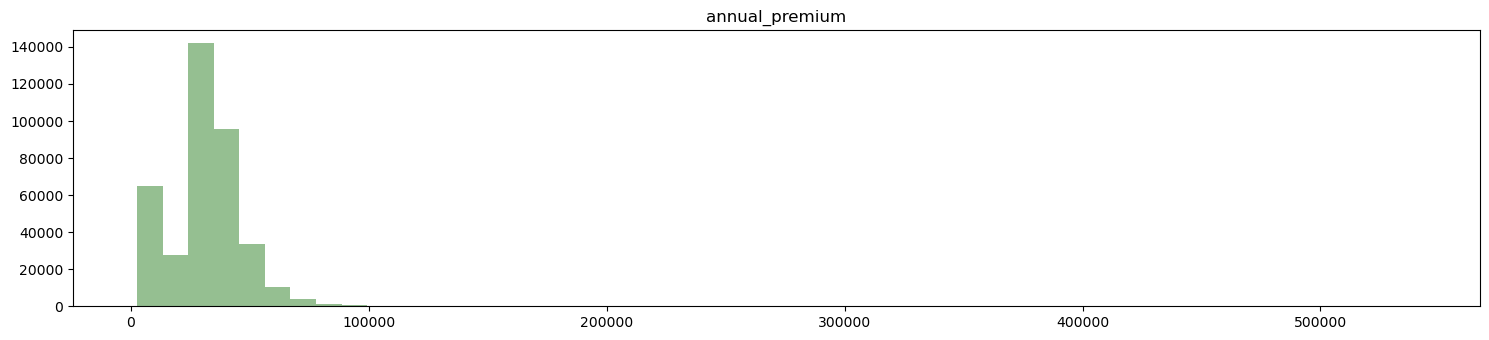

In [24]:
df.hist(column='annual_premium', bins=50, color = '#95BF91', grid=False)

In [25]:
categorical = df.dtypes[df.dtypes == 'object'].index

In [26]:
for col in df.columns:
    print(col) # prints the col name
    print(df[col].unique()[:5]) # prints the first 5 unique values in the col
    print(df[col].nunique()) # calculates the number of unique values in each col
    print()

id
[1 2 3 4 5]
381109

gender
['male' 'female']
2

age
[44 76 47 21 29]
66

driving_license
[1 0]
2

region_code
[28.  3. 11. 41. 33.]
53

previously_insured
[0 1]
2

vehicle_age
['g 2 years' '1-2 year' 'l 1 year']
3

vehicle_damage
['yes' 'no']
2

annual_premium
[40454. 33536. 38294. 28619. 27496.]
48838

policy_sales_channel
[ 26. 152. 160. 124.  14.]
155

vintage
[217 183  27 203  39]
290

response
[1 0]
2



In [27]:
from sklearn.metrics import mutual_info_score

In [28]:
global_response = df.response.mean()
round(global_response, 2)

0.12

In [29]:
df[categorical].nunique()

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

In [30]:
for c in categorical:
    print(c)
    df_group = df.groupby(c).response.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_response
    df_group['risk'] = df_group['mean'] / global_response
    display(df_group)
    print()
    print()
    

gender


,mean,count,diff,risk
gender,,,,
female,0.103902,175020,-0.018661,0.847744
male,0.138411,206089,0.015848,1.129302




vehicle_age


,mean,count,diff,risk
vehicle_age,,,,
1-2 year,0.173755,200316,0.051192,1.417679
g 2 years,0.293746,16007,0.171183,2.396691
l 1 year,0.043705,164786,-0.078858,0.356592




vehicle_damage


,mean,count,diff,risk
vehicle_damage,,,,
no,0.005204,188696,-0.117359,0.042461
yes,0.237655,192413,0.115092,1.939042


In [31]:
def mutual_info_response_score(series):
    return mutual_info_score(df.response, series)

In [32]:
mi = df[categorical].apply(mutual_info_response_score)
mi.sort_values(ascending=False)

vehicle_damage    0.079027
vehicle_age       0.026214
gender            0.001388
dtype: float64

vehicle_damage are the greatest predictor of response.

In [33]:
df[numerical].corrwith(df.response)

id                     -0.001368
age                     0.111147
driving_license         0.010155
region_code             0.010570
previously_insured     -0.341170
annual_premium          0.022575
policy_sales_channel   -0.139042
vintage                -0.001050
response                1.000000
dtype: float64

In [34]:
df.to_csv('cleaned-insurance-cross-sell.csv', index = False)